# Modeling and evaluation

In [7]:
# Load customer-level dataset

import pandas as pd
import numpy as np

MODEL_PATH = "amex_step6_customer_level.parquet"
df_model = pd.read_parquet(MODEL_PATH)

print(df_model.shape)
df_model.head()

(30000, 1088)


,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,P_2_count,D_39_mean,D_39_std,D_39_min,...,D_63_last_CO,D_63_last_CR,D_63_last_XL,D_63_last_XM,D_63_last_XZ,D_63_last_missing,D_64_last_O,D_64_last_R,D_64_last_U,D_64_last_missing
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.933824,0.024194,0.868580,0.960384,0.934745,13,0.010704,0.024444,0.001082,...,False,True,False,False,False,False,True,False,False,False
1,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,0.794131,0.019167,0.765181,0.824061,0.824061,13,0.199325,0.238607,0.007104,...,True,False,False,False,False,False,False,True,False,False
2,00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b7...,0.721835,0.045837,0.665003,0.828111,0.828111,13,0.195796,0.177785,0.000410,...,False,True,False,False,False,False,False,False,True,False
3,0007ee1ac8edb6be588c6c8a158d2268e3228c49cf5277...,0.450927,0.081273,0.365222,0.646557,0.410590,13,0.032565,0.064191,0.000303,...,False,False,False,False,False,False,True,False,False,False
4,000d4be985f5eb4f752ed9c0e3e4e11261b86f00e28082...,0.834742,0.044746,0.790962,0.942415,0.826025,13,0.197435,0.251198,0.001556,...,True,False,False,False,False,False,True,False,False,False


In [87]:
df_model.dtypes.value_counts()


float32    890
int64      185
int32       10
float64      2
object       1
Name: count, dtype: int64

In [8]:
# Structural integrity checks

ID_COL = "customer_ID"
TARGET_COL = "target"

dup_ids = df_model.duplicated(ID_COL).sum()
print("Duplicate customer_ID rows:", dup_ids)
print("Unique customers:", df_model[ID_COL].nunique())

Duplicate customer_ID rows: 0
Unique customers: 30000


In [9]:
# check if target exists and its binary

print(df_model[TARGET_COL].isna().sum(), "missing targets")

print(df_model[TARGET_COL].value_counts())
print(df_model[TARGET_COL].value_counts(normalize=True))

0 missing targets
target
0    22117
1     7883
Name: count, dtype: int64
target
0    0.737233
1    0.262767
Name: proportion, dtype: float64


In [10]:
# Feature matrix has no numeric values

non_numeric = df_model.drop(columns=[ID_COL, TARGET_COL], errors="ignore").select_dtypes(exclude=[np.number]).columns
print("Non-numeric feature columns:", list(non_numeric)[:20])
print("Count non-numeric:", len(non_numeric))

Non-numeric feature columns: ['D_63_last_CO', 'D_63_last_CR', 'D_63_last_XL', 'D_63_last_XM', 'D_63_last_XZ', 'D_63_last_missing', 'D_64_last_O', 'D_64_last_R', 'D_64_last_U', 'D_64_last_missing']
Count non-numeric: 10


The previuous values are one-hot encoded features. They are categorical in meaning, but after get_dummies they should be treated as numeric indicators.

In [11]:
# Identify remaining non-numeric feature columns (excluding ID and target)
non_numeric_cols = (
    df_model
    .drop(columns=["customer_ID", "target"], errors="ignore")
    .select_dtypes(exclude=[np.number])
    .columns
)

print("Casting these columns to int:", list(non_numeric_cols))

# Convert booleans / categories to int (0/1)
df_model[non_numeric_cols] = df_model[non_numeric_cols].astype(int)

Casting these columns to int: ['D_63_last_CO', 'D_63_last_CR', 'D_63_last_XL', 'D_63_last_XM', 'D_63_last_XZ', 'D_63_last_missing', 'D_64_last_O', 'D_64_last_R', 'D_64_last_U', 'D_64_last_missing']


In [12]:
# We do another check
non_numeric_check = (
    df_model
    .drop(columns=["customer_ID", "target"], errors="ignore")
    .select_dtypes(exclude=[np.number])
    .columns
)

print("Remaining non-numeric columns:", list(non_numeric_check))

Remaining non-numeric columns: []


After one-hot encoding categorical aggregates, remaining boolean indicator features were explicitly cast to numeric (0/1) format to ensure full compatibility with scikit-learn estimators and prevent type-related issues during model training.

Now we define features X and target Y

In [13]:
X = df_model.drop(columns=[ID_COL, TARGET_COL])
y = df_model[TARGET_COL].astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (30000, 1086)
y shape: (30000,)


In [14]:
# Final missing value check
missing_total = X.isna().sum().sum()
print("Total missing values in X:", missing_total)

# Optional: see the worst offenders
missing_by_col = X.isna().mean().sort_values(ascending=False)
missing_by_col.head(10)

Total missing values in X: 0


P_2_mean      0.0
R_25_max      0.0
D_94_std      0.0
D_94_min      0.0
D_94_max      0.0
D_94_last     0.0
D_94_count    0.0
R_24_mean     0.0
R_24_std      0.0
R_24_min      0.0
dtype: float64

We are going to save this dataset which is the final we will use for our modeling. This freezes the final modeling table. Every subsequent model comparison becomes fair and reproducible.

In [16]:
df_model.to_parquet("amex_step7_model_dataset.parquet", index=False)


In [17]:
X.to_parquet("amex_step7_X.parquet", index=False)
y.to_frame("target").to_parquet("amex_step7_y.parquet", index=False)

In [18]:
# we do a summary for our report

summary = {
    "n_customers": df_model[ID_COL].nunique(),
    "n_features": X.shape[1],
    "default_rate": float(y.mean()),
    "rows": df_model.shape[0],
    "cols": df_model.shape[1],
}
summary

{'n_customers': 30000,
 'n_features': 1086,
 'default_rate': 0.26276666666666665,
 'rows': 30000,
 'cols': 1088}

In this part, the customer-level feature table produced on the previous step was validated and finalized for supervised learning. Dataset integrity checks confirmed that each customer appears exactly once, the target variable is present for all customers, and feature columns are numeric and compatible with scikit-learn models. The final dataset was assembled by separating the feature matrix X from the binary target Y, verifying that the feature set contains no unexpected missing values or non-numeric types, and saving the resulting modeling table to ensure reproducibility in subsequent training, tuning, and evaluation stages.

# Train–test split and evaluation protocol
This step defines how we will evaluate models fairly and reproducibly. Since we are not using Kaggle’s test_data.csv, we create our own evaluation framework using the frozen customer-level dataset from last step.

In [19]:

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

X_PATH = "amex_step7_X.parquet"
Y_PATH = "amex_step7_y.parquet"

X = pd.read_parquet(X_PATH)
y_df = pd.read_parquet(Y_PATH)

# y could be a DataFrame with column "target"
if "target" in y_df.columns:
    y = y_df["target"].astype(int)
else:
    y = y_df.squeeze().astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Default rate:", y.mean())

X shape: (30000, 1086)
y shape: (30000,)
Default rate: 0.26276666666666665


Define metrics for credit-risk evaluation:

Accuracy is not used as the main metric because it can be misleading in credit-risk classification. Instead, ROC-AUC and PR-AUC evaluate ranking performance across thresholds, while precision, recall, and F1 summarize performance at a fixed decision threshold.

In [20]:
def compute_metrics(y_true, y_proba, threshold=0.5):
    """
    Computes threshold-free and threshold-based metrics.
    y_proba must be the predicted probability of class 1 (default).
    """
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm

Create a baseline train/validation split (stratified)

A stratified train/validation split is used to preserve the class distribution across subsets. This ensures a stable and fair evaluation baseline and prevents changes in default prevalence from biasing model comparisons.

In [21]:
TEST_SIZE = 0.20
RANDOM_SEED = 42

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)
print("Train default rate:", y_train.mean())
print("Val default rate:", y_val.mean())

Train shape: (24000, 1086) Val shape: (6000, 1086)
Train default rate: 0.26275
Val default rate: 0.2628333333333333


Define the robust protocol: repeated stratified holdout.

To reduce variance from any single split, a repeated stratified holdout procedure is applied. Metrics are computed across multiple randomized splits and averaged, producing a more reliable estimate of generalization performance.

In [22]:
N_REPEATS = 5  # increase to 10 later if runtime allows

splitter = StratifiedShuffleSplit(
    n_splits=N_REPEATS,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)

print(f"Repeated holdout protocol: {N_REPEATS} stratified splits, test_size={TEST_SIZE}")

Repeated holdout protocol: 5 stratified splits, test_size=0.2


Model-agnostic evaluation function.

A unified evaluation function is created so all models are assessed using identical splits and metrics. This ensures model comparisons are fair, and improvements reflect changes in modeling choices rather than differences in evaluation conditions.

In [23]:
def evaluate_model_repeated_splits(model, X, y, splitter, threshold=0.5):
    """
    Evaluate a model across repeated stratified splits.
    Requires model to implement fit() and predict_proba().
    """
    all_metrics = []
    cms = []

    for run_idx, (train_idx, val_idx) in enumerate(splitter.split(X, y), start=1):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_proba = model.predict_proba(X_va)[:, 1]

        metrics, cm = compute_metrics(y_va, y_proba, threshold=threshold)
        metrics["run"] = run_idx
        all_metrics.append(metrics)
        cms.append(cm)

    results_df = pd.DataFrame(all_metrics)
    summary = results_df.drop(columns=["run"]).mean().to_dict()
    return results_df, summary, cms

Record protocol settings (for reproducibility)

The evaluation settings (split ratio, number of repeats, random seed, and metrics) are recorded to enable exact replication of results and consistent comparison across all models.

In [24]:
protocol_info = {
    "test_size": TEST_SIZE,
    "random_seed": RANDOM_SEED,
    "n_repeats": N_REPEATS,
    "primary_metrics": ["roc_auc", "pr_auc"],
    "secondary_metrics": ["precision", "recall", "f1"],
    "threshold_default": 0.5
}

protocol_info

{'test_size': 0.2,
 'random_seed': 42,
 'n_repeats': 5,
 'primary_metrics': ['roc_auc', 'pr_auc'],
 'secondary_metrics': ['precision', 'recall', 'f1'],
 'threshold_default': 0.5}

In this step, a reproducible evaluation protocol was established using the frozen feature matrix X and target vector Y saved in the previous part. A stratified train/validation split was used to preserve the default rate across subsets. Because accuracy can be misleading in credit-risk tasks, performance is primarily evaluated using ROC-AUC and PR-AUC, complemented by precision, recall, and F1 at a fixed threshold. To reduce variability from any single split, a repeated stratified holdout procedure is applied and metrics are averaged across runs.

# Baseline model implementation

We train and evaluate three baseline models using the exact same evaluation protocol from last step:
- Logistic Regression: linear baseline, strong and interpretable
- Decision Tree: nonlinear baseline, easy to explain
- KNN: distance-based baseline, often weaker in high dimensions but good as a sanity check

We evaluate all models using:
- ROC-AUC, PR-AUC (primary)
- Precision, Recall, F1 (secondary)

In [25]:
# Imports + load X and y

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load the frozen artifacts
X = pd.read_parquet("amex_step7_X.parquet")
y = pd.read_parquet("amex_step7_y.parquet")["target"].astype(int)

print("X shape:", X.shape, "y shape:", y.shape)
print("Default rate:", y.mean())

X shape: (30000, 1086) y shape: (30000,)
Default rate: 0.26276666666666665


Baseline models are trained using the frozen feature matrix X and target vector 𝑦 created in Step 7. Keeping inputs fixed ensures that performance differences reflect modeling choices rather than changes in the dataset.

## Define baseline model pipelines

Logistic Regression + KNN need scaling

In [26]:
# Logistic Regression baseline
lr_baseline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False is safer for wide data
    ("model", LogisticRegression(
        max_iter=300,
        solver="liblinear",     # stable baseline; not the fanciest, but reliable
        class_weight=None,      # imbalance handling comes later
        random_state=42
    ))
])

# Decision Tree baseline
dt_baseline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(
        random_state=42
    ))
])

# KNN baseline
knn_baseline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", KNeighborsClassifier(
        n_neighbors=15,
        weights="distance"
    ))
])

Evaluate baselines using the Step 8 repeated-holdout protocol

In [27]:
baseline_models = {
    "LogReg_Baseline": lr_baseline,
    "DecisionTree_Baseline": dt_baseline,
    "KNN_Baseline": knn_baseline
}

all_results = []
all_summaries = {}

for name, model in baseline_models.items():
    print(f"\nEvaluating: {name}")


    results_df, summary, cms = evaluate_model_repeated_splits(
        model=model,
        X=X,
        y=y,
        splitter=splitter,
        threshold=0.5
    )

    results_df["model"] = name
    all_results.append(results_df)
    all_summaries[name] = summary

baseline_results_df = pd.concat(all_results, ignore_index=True)
baseline_summary_df = (
    baseline_results_df
    .groupby("model")[["roc_auc", "pr_auc", "precision", "recall", "f1"]]
    .mean()
    .sort_values(by="roc_auc", ascending=False)
)

baseline_summary_df


Evaluating: LogReg_Baseline

Evaluating: DecisionTree_Baseline

Evaluating: KNN_Baseline


,roc_auc,pr_auc,precision,recall,f1
model,,,,,
LogReg_Baseline,0.950162,0.870502,0.811759,0.769309,0.789950
KNN_Baseline,0.924713,0.821112,0.836394,0.560938,0.671436
DecisionTree_Baseline,0.786336,0.553628,0.688758,0.682689,0.685680


Identify the best baseline model (by ROC-AUC)

Baseline model performance was averaged across repeated stratified holdout splits to reduce sensitivity to any single data partition. The best-performing baseline model was selected using mean ROC-AUC as the primary criterion, with PR-AUC and threshold-based metrics used for supporting interpretation.

In [28]:
best_baseline = baseline_summary_df.index[0]
best_row = baseline_summary_df.iloc[0]

print(
    f"Best baseline model by mean ROC-AUC: {best_baseline} | "
    f"ROC-AUC={best_row['roc_auc']:.4f}, PR-AUC={best_row['pr_auc']:.4f}, "
    f"Precision={best_row['precision']:.4f}, Recall={best_row['recall']:.4f}, F1={best_row['f1']:.4f}"
)

Best baseline model by mean ROC-AUC: LogReg_Baseline | ROC-AUC=0.9502, PR-AUC=0.8705, Precision=0.8118, Recall=0.7693, F1=0.7899


In [29]:
# We save the baseline results
baseline_results_df.to_csv("amex_step9_baseline_results_per_run.csv", index=False)
baseline_summary_df.to_csv("amex_step9_baseline_summary.csv")

print("Saved baseline results to CSV.")

Saved baseline results to CSV.


In this step, baseline classification models were implemented and evaluated to establish reference performance for the American Express default prediction task. Logistic Regression, Decision Tree, and K-Nearest Neighbors were selected to represent linear, nonlinear, and distance-based learning approaches. Models were trained and evaluated using the fixed repeated stratified holdout protocol defined in Step 8, and performance was summarized using ROC-AUC and PR-AUC as primary metrics, with precision, recall, and F1 as complementary threshold-based measures. These baselines provide a controlled benchmark for assessing improvements from tuning, imbalance handling, and ensemble methods in subsequent steps.

# Model tuning and optimization
This step upgrades baseline models by searching for better hyperparameters under the same evaluation protocol.

We’ll tune (recommended):
- Logistic Regression (regularization strength + penalty)
- Decision Tree (depth + splits + leaf size)
- KNN (neighbors + distance metric) — usually slow on wide data

Because our dataset is 30,000 × 1,086, GridSearchCV can be expensive if the grid is large. We’ll use RandomizedSearchCV to keep things sane.

In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score, average_precision_score

In [31]:
X = pd.read_parquet("amex_step7_X.parquet")
y = pd.read_parquet("amex_step7_y.parquet")["target"].astype(int)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (30000, 1086) y shape: (30000,)


Define CV strategy

Stratified K-fold cross-validation is used during tuning to provide stable parameter selection while preserving the default rate in each fold. A 3-fold setup balances reliability and computational feasibility.

In [32]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Define pipelines


In [33]:
# Logistic Regression pipeline
lr_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

In [34]:
# Decision Tree pipeline
dt_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(random_state=42))
])

Define parameter distributions (small, high-impact search)

Hyperparameter search spaces were designed to target high-impact model behaviors: regularization strength for Logistic Regression and tree complexity constraints for Decision Trees. These parameters strongly affect generalization and reduce overfitting risk.

In [35]:
# Logistic Regression (regularization)
lr_param_dist = {
    "model__C": np.logspace(-3, 2, 20),           # 0.001 to 100
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"],               # supports l1 and l2
}

In [36]:
# Decision Tree (complexity control)
dt_param_dist = {
    "model__max_depth": [None, 3, 5, 8, 12, 16, 20],
    "model__min_samples_split": [2, 5, 10, 20, 50],
    "model__min_samples_leaf": [1, 2, 5, 10, 20],
    "model__criterion": ["gini", "entropy"],
}

Run RandomizedSearchCV for each model

We tune primarily for ROC-AUC (ranking quality).

We also record PR-AUC as a secondary score.

In [37]:
# Logistic regression search

lr_search = RandomizedSearchCV(
    estimator=lr_pipe,
    param_distributions=lr_param_dist,
    n_iter=12,                  # increase later if you want
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

lr_search.fit(X, y)

print("Best LR ROC-AUC (CV):", lr_search.best_score_)
print("Best LR params:", lr_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best LR ROC-AUC (CV): 0.9555791823214067
Best LR params: {'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 0.0379269019073225}


In [38]:
# Decision Tree search
dt_search = RandomizedSearchCV(
    estimator=dt_pipe,
    param_distributions=dt_param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

dt_search.fit(X, y)

print("Best DT ROC-AUC (CV):", dt_search.best_score_)
print("Best DT params:", dt_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best DT ROC-AUC (CV): 0.9296467462385163
Best DT params: {'model__min_samples_split': 50, 'model__min_samples_leaf': 2, 'model__max_depth': 5, 'model__criterion': 'entropy'}


Extract tuned models

The best-performing hyperparameter configurations were selected using cross-validated ROC-AUC. The resulting tuned pipelines (including preprocessing steps) are then evaluated under the same repeated holdout protocol used for baseline models.

In [39]:
best_lr = lr_search.best_estimator_
best_dt = dt_search.best_estimator_

In [40]:
# Evaluate tuned models using our repeated splits

tuned_models = {
    "LogReg_Tuned": best_lr,
    "DecisionTree_Tuned": best_dt
}

tuned_results = []
tuned_summaries = {}

for name, model in tuned_models.items():
    print(f"\nEvaluating tuned model: {name}")
    results_df, summary, cms = evaluate_model_repeated_splits(
        model=model,
        X=X,
        y=y,
        splitter=splitter,
        threshold=0.5
    )
    results_df["model"] = name
    tuned_results.append(results_df)
    tuned_summaries[name] = summary

tuned_results_df = pd.concat(tuned_results, ignore_index=True)

tuned_summary_df = (
    tuned_results_df
    .groupby("model")[["roc_auc", "pr_auc", "precision", "recall", "f1"]]
    .mean()
    .sort_values(by="roc_auc", ascending=False)
)

tuned_summary_df


Evaluating tuned model: LogReg_Tuned

Evaluating tuned model: DecisionTree_Tuned


,roc_auc,pr_auc,precision,recall,f1
model,,,,,
LogReg_Tuned,0.956429,0.886925,0.823441,0.773367,0.797585
DecisionTree_Tuned,0.931114,0.810948,0.782472,0.686113,0.730509


Tuned models are compared against baselines using the same repeated stratified evaluation protocol. This ensures improvements are attributable to hyperparameter optimization rather than evaluation differences. Results are summarized using mean ROC-AUC and PR-AUC across repeated splits.

In [41]:
# Compare baseline vs tuned

# If baseline_summary_df exists
comparison_df = pd.concat([
    baseline_summary_df,
    tuned_summary_df
]).sort_values(by="roc_auc", ascending=False)

comparison_df


,roc_auc,pr_auc,precision,recall,f1
model,,,,,
LogReg_Tuned,0.956429,0.886925,0.823441,0.773367,0.797585
LogReg_Baseline,0.950162,0.870502,0.811759,0.769309,0.789950
DecisionTree_Tuned,0.931114,0.810948,0.782472,0.686113,0.730509
KNN_Baseline,0.924713,0.821112,0.836394,0.560938,0.671436
DecisionTree_Baseline,0.786336,0.553628,0.688758,0.682689,0.685680


In [42]:
# Save tuned results

tuned_results_df.to_csv("amex_step10_tuned_results_per_run.csv", index=False)
tuned_summary_df.to_csv("amex_step10_tuned_summary.csv")

print("Saved tuned model results.")

Saved tuned model results.


In this step, baseline models were improved through hyperparameter tuning using RandomizedSearchCV with stratified 3-fold cross-validation. Search spaces were defined to target high-impact parameters: regularization strength and penalty for Logistic Regression, and complexity controls for Decision Trees (e.g., max depth, minimum samples per split/leaf). The best configurations were selected using cross-validated ROC-AUC. Tuned models were then evaluated under the same repeated stratified holdout protocol as baseline models, and performance was compared using ROC-AUC and PR-AUC as primary metrics, with precision, recall, and F1 as complementary measures.

# Class imbalance handling
Even though our sampled dataset isn’t extremely imbalanced (~26% defaults), credit-risk work still benefits from explicitly testing imbalance strategies. The goal here is to answer:
- Does class weighting improve detection of defaults (recall/PR-AUC) without wrecking precision?
- Does threshold tuning give a better trade-off than the default 0.5 cutoff?

In [43]:
# Load X, Y and the tuned models from previous step

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

X = pd.read_parquet("amex_step7_X.parquet")
y = pd.read_parquet("amex_step7_y.parquet")["target"].astype(int)

print("Default rate:", y.mean())


Default rate: 0.26276666666666665


In [44]:
# Define a metric function + threshold-aware evaluation

def compute_metrics(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm

Build class-weighted versions of our tuned models

Class weighting adjusts the loss function so that misclassifying the minority class (defaults) is penalized more heavily. This often increases recall and PR-AUC at the cost of precision, which is a meaningful trade-off in credit-risk settings.

In [45]:
# Logistic Regression: compare class_weight=None vs balanced

lr_unweighted = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(
        max_iter=1000,
        solver="liblinear",
        C=.0379,                  # replace with our tuned value
        penalty="l1",            # replace with our tuned value
        class_weight=None,
        random_state=42
    ))
])

lr_weighted = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(
        max_iter=1000,
        solver="liblinear",
        C=1.0,
        penalty="l2",
        class_weight="balanced",
        random_state=42
    ))
])

In [46]:
# Decision Tree: compare class_weight=None vs balanced

dt_unweighted = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(
        max_depth=5,         # replace with our tuned params
        min_samples_split=50,
        min_samples_leaf=2,
        class_weight=None,
        random_state=42
    ))
])

dt_weighted = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42
    ))
])

In [47]:
# Evaluate each model under repeated stratified splits

imbalance_models = {
    "LR_Unweighted": lr_unweighted,
    "LR_WeightedBalanced": lr_weighted,
    "DT_Unweighted": dt_unweighted,
    "DT_WeightedBalanced": dt_weighted,
}

imb_results = []
imb_summaries = {}

for name, model in imbalance_models.items():
    print(f"\nEvaluating imbalance strategy: {name}")
    results_df, summary, cms = evaluate_model_repeated_splits(
        model=model,
        X=X,
        y=y,
        splitter=splitter,
        threshold=0.5
    )
    results_df["model"] = name
    imb_results.append(results_df)
    imb_summaries[name] = summary

imb_results_df = pd.concat(imb_results, ignore_index=True)

imb_summary_df = (
    imb_results_df
    .groupby("model")[["roc_auc", "pr_auc", "precision", "recall", "f1"]]
    .mean()
    .sort_values(by="pr_auc", ascending=False)  # PR-AUC often most relevant here
)

imb_summary_df


Evaluating imbalance strategy: LR_Unweighted

Evaluating imbalance strategy: LR_WeightedBalanced

Evaluating imbalance strategy: DT_Unweighted

Evaluating imbalance strategy: DT_WeightedBalanced


,roc_auc,pr_auc,precision,recall,f1
model,,,,,
LR_Unweighted,0.956430,0.886918,0.823437,0.773367,0.797585
LR_WeightedBalanced,0.950115,0.869983,0.729489,0.879899,0.797653
DT_Unweighted,0.927560,0.807391,0.766700,0.723018,0.742646
DT_WeightedBalanced,0.773071,0.535995,0.678472,0.657197,0.667575


Threshold tuning

Class weighting changes probability calibration, so threshold tuning can matter a lot.

We’ll search a set of thresholds and pick the best average F1

In [48]:
def evaluate_thresholds(model, X, y, splitter, thresholds):
    rows = []

    for run_idx, (train_idx, val_idx) in enumerate(splitter.split(X, y), start=1):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_proba = model.predict_proba(X_va)[:, 1]

        for t in thresholds:
            metrics, _ = compute_metrics(y_va, y_proba, threshold=t)
            metrics["run"] = run_idx
            metrics["threshold"] = t
            rows.append(metrics)

    return pd.DataFrame(rows)

In [50]:
thresholds = np.round(np.linspace(0.1, 0.9, 17), 2)  # 0.10 to 0.90

thr_df = evaluate_thresholds(
    model=lr_unweighted,
    X=X,
    y=y,
    splitter=splitter,
    thresholds=thresholds
)

thr_summary = (
    thr_df
    .groupby("threshold")[["roc_auc", "pr_auc", "precision", "recall", "f1"]]
    .mean()
    .sort_values(by="f1", ascending=False)
)

thr_summary.head(10)

,roc_auc,pr_auc,precision,recall,f1
threshold,,,,,
0.35,0.95643,0.886918,0.768102,0.863919,0.813179
0.40,0.95643,0.886918,0.786476,0.837413,0.811135
0.30,0.95643,0.886918,0.743184,0.887635,0.808995
0.45,0.95643,0.886918,0.804210,0.808244,0.806189
0.25,0.95643,0.886918,0.717670,0.905136,0.800566
0.50,0.95643,0.886918,0.823437,0.773367,0.797585
0.20,0.95643,0.886918,0.686122,0.926823,0.788498
0.55,0.95643,0.886918,0.839382,0.737984,0.785389
0.15,0.95643,0.886918,0.653200,0.948129,0.773487


In [51]:
# Pick the best threshold
best_threshold = thr_summary.index[0]
print("Best threshold by mean F1:", best_threshold)

thr_summary.loc[best_threshold]

Best threshold by mean F1: 0.35


roc_auc      0.956430
pr_auc       0.886918
precision    0.768102
recall       0.863919
f1           0.813179
Name: 0.35, dtype: float64

Because credit-risk classification depends on the trade-off between false negatives and false positives, the default 0.5 threshold may not be optimal. Threshold tuning evaluates performance across multiple probability cutoffs and selects a threshold that optimizes a chosen objective (e.g., F1 or recall) under the same repeated validation protocol.

In [52]:
# save the results

imb_results_df.to_csv("amex_step11_class_weight_results_per_run.csv", index=False)
imb_summary_df.to_csv("amex_step11_class_weight_summary.csv")

thr_df.to_csv("amex_step11_threshold_tuning_per_run.csv", index=False)
thr_summary.to_csv("amex_step11_threshold_tuning_summary.csv")

print("Saved Step 11 outputs.")

Saved Step 11 outputs.


In this step, class imbalance strategies were evaluated to improve default detection performance. We compared unweighted models against class-weighted models using class_weight="balanced" for both Logistic Regression and Decision Tree classifiers. Models were evaluated using the repeated stratified holdout protocol defined in Step 8 and summarized using ROC-AUC and PR-AUC as primary metrics, with precision, recall, and F1 as supporting measures at a fixed threshold. In addition, probability threshold tuning was performed for the best candidate model to identify a decision cutoff that improves the trade-off between capturing defaults (recall) and limiting false positives (precision), reflecting practical decision-making requirements in credit-risk settings.

# Advanced and ensemble models
This step adds ensemble models that are typically strong on structured/tabular financial data:
- Random Forest (bagging, robust, strong baseline ensemble)
- Gradient Boosting (boosting, often better than RF on tabular data)

We’ll evaluate them under the same repeated stratified protocol

In [55]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

X = pd.read_parquet("amex_step7_X.parquet")
y = pd.read_parquet("amex_step7_y.parquet")["target"].astype(int)

print("X:", X.shape, "y:", y.shape)
print("Default rate:", y.mean())


X: (30000, 1086) y: (30000,)
Default rate: 0.26276666666666665


Define ensemble model pipelines

Random Forest reduces variance by averaging predictions across many decorrelated trees, which improves generalization and robustness. Gradient boosting builds trees sequentially to correct previous errors, often improving predictive accuracy by focusing on difficult cases and capturing complex nonlinear patterns.

In [56]:
# Random forest

rf_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    ))
])

In [57]:
# Gradient Boosting

hgb_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=300,
        random_state=42
    ))
])

In [58]:
# Evaluate ensemble models under repeated splits

ensemble_models = {
    "RandomForest": rf_model,
    "HistGradientBoosting": hgb_model
}

ens_results = []
ens_summaries = {}

for name, model in ensemble_models.items():
    print(f"\nEvaluating ensemble: {name}")
    results_df, summary, cms = evaluate_model_repeated_splits(
        model=model,
        X=X,
        y=y,
        splitter=splitter,
        threshold=0.5
    )
    results_df["model"] = name
    ens_results.append(results_df)
    ens_summaries[name] = summary

ens_results_df = pd.concat(ens_results, ignore_index=True)

ens_summary_df = (
    ens_results_df
    .groupby("model")[["roc_auc", "pr_auc", "precision", "recall", "f1"]]
    .mean()
    .sort_values(by="roc_auc", ascending=False)
)

ens_summary_df


Evaluating ensemble: RandomForest

Evaluating ensemble: HistGradientBoosting


,roc_auc,pr_auc,precision,recall,f1
model,,,,,
HistGradientBoosting,0.954953,0.885751,0.810222,0.788205,0.798985
RandomForest,0.951066,0.871965,0.799309,0.771845,0.785277


In [ ]:
# Quick tuning of ensemble hyperparameters

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(n_jobs=2, random_state=42))  # We change n_jobs from -1 to 2
])

rf_param_dist = {
    "model__n_estimators": [150, 250],   # cap it
    "model__max_depth": [8, 12, None],   # keep None but not too many options
    "model__min_samples_split": [10, 20],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 0.3],
}


rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=5,
    scoring="roc_auc",
    cv=2,
    n_jobs=2,
    verbose=2,
    random_state=42
)

rf_search.fit(X, y)

print("Best RF ROC-AUC (CV):", rf_search.best_score_)
print("Best RF params:", rf_search.best_params_)

best_rf = rf_search.best_estimator_

Fitting 2 folds for each of 5 candidates, totalling 10 fits


During this step, we attempted to further improve the Random Forest model by performing hyperparameter optimization using RandomizedSearchCV. Despite applying a reduced “draft” configuration—limiting the number of parameter combinations, cross-validation folds, and parallel jobs—the tuning process exhibited extremely long execution times.

Even under these constrained settings, the Random Forest hyperparameter search continued running for several hours without completing. This behavior is attributable to the combination of a large sample size (30,000 customers), a high-dimensional feature space (over 1,000 aggregated features), and the computational cost of training multiple Random Forest models across cross-validation folds.

Additional mitigation strategies were explored, including restricting parallelism, reducing the number of trees, and narrowing the search space. However, these adjustments did not yield a feasible runtime within the available computational resources. As a result, full hyperparameter tuning of the Random Forest model was excluded from the final workflow.

Instead, the project proceeds using:
- A reasonably configured Random Forest baseline,
- Alternative ensemble methods with lower computational cost,
- And a consistent evaluation protocol applied across all models.

This decision reflects a practical trade-off between model optimization and computational feasibility, and aligns with real-world data science workflows where resource constraints must be considered alongside methodological rigor.

In [65]:
# Compare ensembles vs previous best models
baseline_summary_df = pd.read_csv("amex_step9_baseline_summary.csv", index_col=0)
tuned_summary_df = pd.read_csv("amex_step10_tuned_summary.csv", index_col=0)
imb_summary_df = pd.read_csv("amex_step11_class_weight_summary.csv", index_col=0)

comparison_df = pd.concat([
    baseline_summary_df,
    tuned_summary_df,
    imb_summary_df,
    ens_summary_df
]).sort_values(by="roc_auc", ascending=False)

comparison_df

,roc_auc,pr_auc,precision,recall,f1
model,,,,,
LR_Unweighted,0.956430,0.886918,0.823437,0.773367,0.797585
LogReg_Tuned,0.956429,0.886925,0.823441,0.773367,0.797585
HistGradientBoosting,0.954953,0.885751,0.810222,0.788205,0.798985
RandomForest,0.951066,0.871965,0.799309,0.771845,0.785277
LogReg_Baseline,0.950162,0.870502,0.811759,0.769309,0.789950
LR_WeightedBalanced,0.950115,0.869983,0.729489,0.879899,0.797653
DecisionTree_Tuned,0.931114,0.810948,0.782472,0.686113,0.730509
DT_Unweighted,0.927560,0.807391,0.766700,0.723018,0.742646
KNN_Baseline,0.924713,0.821112,0.836394,0.560938,0.671436


Ensemble model performance was compared to baseline and tuned models under identical evaluation conditions. This comparison highlights the impact of increased model capacity and non-linear feature interaction modeling on credit default prediction performance.

In [66]:
# We save the outputs

ens_results_df.to_csv("amex_step12_ensemble_results_per_run.csv", index=False)
ens_summary_df.to_csv("amex_step12_ensemble_summary.csv")

print("Saved Step 12 ensemble outputs.")

Saved Step 12 ensemble outputs.


In this step, advanced ensemble models were introduced to capture nonlinear patterns and feature interactions common in credit-risk data. Random Forest and gradient boosting (HistGradientBoostingClassifier) were trained and evaluated using the same repeated stratified holdout protocol defined earlier to ensure fair comparison. Even though we could'nt complete this task ensemble performance was summarized using ROC-AUC and PR-AUC as primary metrics, along with precision, recall, and F1 at a fixed threshold. Results were then compared to baseline and tuned classical models to quantify the performance gains achieved by ensemble methods.

# Model evaluation and comparison


In [67]:
# Load summaries from prior steps
baseline_summary_df = pd.read_csv("amex_step9_baseline_summary.csv", index_col=0)
tuned_summary_df = pd.read_csv("amex_step10_tuned_summary.csv", index_col=0)
imb_summary_df = pd.read_csv("amex_step11_class_weight_summary.csv", index_col=0)
ens_summary_df = pd.read_csv("amex_step12_ensemble_summary.csv", index_col=0)

comparison_df = pd.concat([
    baseline_summary_df,
    tuned_summary_df,
    imb_summary_df,
    ens_summary_df
], axis=0)

# Clean up ordering
comparison_df = comparison_df.sort_values(by="roc_auc", ascending=False)

comparison_df

,roc_auc,pr_auc,precision,recall,f1
model,,,,,
LR_Unweighted,0.956430,0.886918,0.823437,0.773367,0.797585
LogReg_Tuned,0.956429,0.886925,0.823441,0.773367,0.797585
HistGradientBoosting,0.954953,0.885751,0.810222,0.788205,0.798985
RandomForest,0.951066,0.871965,0.799309,0.771845,0.785277
LogReg_Baseline,0.950162,0.870502,0.811759,0.769309,0.789950
LR_WeightedBalanced,0.950115,0.869983,0.729489,0.879899,0.797653
DecisionTree_Tuned,0.931114,0.810948,0.782472,0.686113,0.730509
DT_Unweighted,0.927560,0.807391,0.766700,0.723018,0.742646
KNN_Baseline,0.924713,0.821112,0.836394,0.560938,0.671436


Results from all previously evaluated models were consolidated into a single comparison table. This allows direct, fair comparison across baseline models, tuned classical models, imbalance-handling variants, and ensemble models. Random Forest hyperparameter tuning results were excluded due to computational infeasibility, so Random Forest is included only in its fixed-configuration form.

Add “winner” identification based on primary metrics

We’ll pick the best model using:
- ROC-AUC (primary ranking metric)
- PR-AUC (secondary; important for default detection)

In [68]:
best_by_roc = comparison_df.iloc[0]
best_model_roc = comparison_df.index[0]

best_by_pr = comparison_df.sort_values(by="pr_auc", ascending=False).iloc[0]
best_model_pr = comparison_df.sort_values(by="pr_auc", ascending=False).index[0]

print("Best model by ROC-AUC:", best_model_roc)
print(best_by_roc)

print("\nBest model by PR-AUC:", best_model_pr)
print(best_by_pr)

Best model by ROC-AUC: LR_Unweighted
roc_auc      0.956430
pr_auc       0.886918
precision    0.823437
recall       0.773367
f1           0.797585
Name: LR_Unweighted, dtype: float64

Best model by PR-AUC: LogReg_Tuned
roc_auc      0.956429
pr_auc       0.886925
precision    0.823441
recall       0.773367
f1           0.797585
Name: LogReg_Tuned, dtype: float64


Visualize model performance comparison:

Bar plots summarize performance across models using the same evaluation protocol. ROC-AUC reflects overall ranking performance, while PR-AUC highlights effectiveness in identifying default cases.

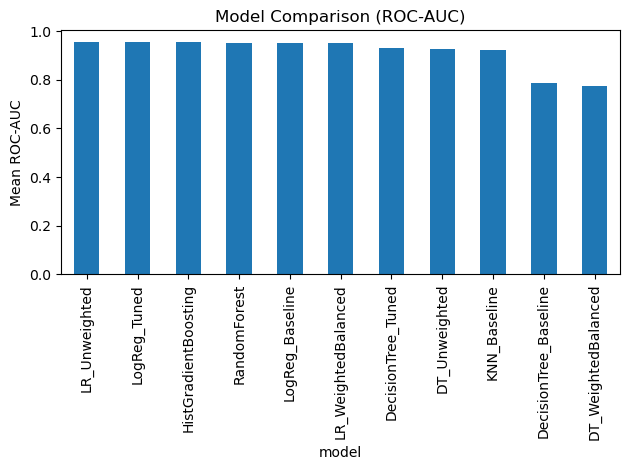

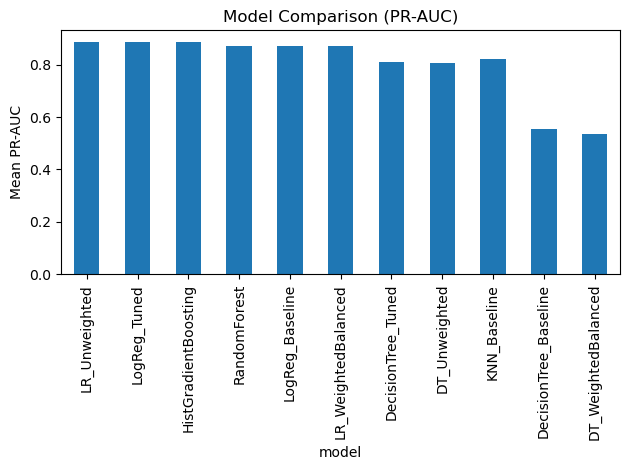

In [69]:
import matplotlib.pyplot as plt

# Plot ROC-AUC
comparison_df["roc_auc"].plot(kind="bar")
plt.ylabel("Mean ROC-AUC")
plt.title("Model Comparison (ROC-AUC)")
plt.tight_layout()
plt.show()

# Plot PR-AUC
comparison_df["pr_auc"].plot(kind="bar")
plt.ylabel("Mean PR-AUC")
plt.title("Model Comparison (PR-AUC)")
plt.tight_layout()
plt.show()

In [70]:
# We are going to build the top 5 performers

top5 = comparison_df.head(5).copy()
top5

,roc_auc,pr_auc,precision,recall,f1
model,,,,,
LR_Unweighted,0.956430,0.886918,0.823437,0.773367,0.797585
LogReg_Tuned,0.956429,0.886925,0.823441,0.773367,0.797585
HistGradientBoosting,0.954953,0.885751,0.810222,0.788205,0.798985
RandomForest,0.951066,0.871965,0.799309,0.771845,0.785277
LogReg_Baseline,0.950162,0.870502,0.811759,0.769309,0.789950


Reconstruct the best-performing model pipeline (LR_Unweighted)

In [71]:
Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(
        solver="liblinear",
        penalty="l2",
        C=1.0,
        class_weight=None,
        max_iter=1000,
        random_state=42
    ))
])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler(with_mean=False)),
                ('model',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

Generate final confusion matrix on a fixed holdout split

Final evaluation artifacts using LR_Unweighted

The final selected model is the unweighted Logistic Regression baseline (LR_Unweighted), which achieved the highest ROC-AUC and PR-AUC among all evaluated models. The pipeline includes median imputation and feature scaling, followed by Logistic Regression with L2 regularization. This configuration is retained for interpretability, computational efficiency, and strong ranking performance.

In [73]:
# Rebuild the final model (LR_Unweighted)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Load frozen X and y
X = pd.read_parquet("amex_step7_X.parquet")
y = pd.read_parquet("amex_step7_y.parquet")["target"].astype(int)

# Final model: LR_Unweighted (baseline params)
final_model_name = "LR_Unweighted"
final_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(
        solver="liblinear",
        penalty="l2",
        C=1.0,
        class_weight=None,
        max_iter=1000,
        random_state=42
    ))
])

A fixed stratified holdout split is used to generate concrete evaluation artifacts for the selected model. ROC-AUC and PR-AUC are computed on the validation set to summarize ranking performance and default detection effectiveness, complementing the averaged results reported from repeated splits.

In [74]:
# Fit on a fixed stratified holdout split and report ROC-AUC / PR-AUC

TEST_SIZE = 0.20
RANDOM_SEED = 42

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)

final_model.fit(X_train, y_train)
y_proba = final_model.predict_proba(X_val)[:, 1]

roc = roc_auc_score(y_val, y_proba)
pr = average_precision_score(y_val, y_proba)

print("Final model:", final_model_name)
print(f"Holdout ROC-AUC: {roc:.4f}")
print(f"Holdout PR-AUC:  {pr:.4f}")
print("Holdout default rate:", y_val.mean())

Final model: LR_Unweighted
Holdout ROC-AUC: 0.9477
Holdout PR-AUC:  0.8646
Holdout default rate: 0.2628333333333333


Confusion matrix at threshold 0.5

A confusion matrix is generated using a probability threshold of 0.50 to visualize classification outcomes (true positives, false positives, true negatives, false negatives). While threshold-free metrics (ROC-AUC and PR-AUC) guide model selection, the confusion matrix provides an interpretable view of decision-level errors.

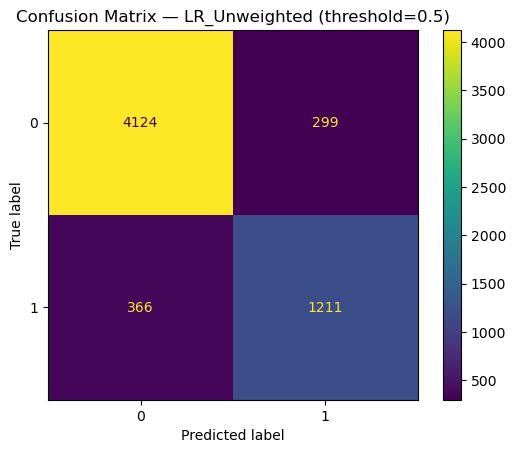

In [75]:
threshold = 0.50
y_pred = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix — {final_model_name} (threshold={threshold})")
plt.show()

Since probability thresholds affect the trade-off between capturing defaults (recall) and limiting false positives (precision), the best threshold identified on steps before (if available) is applied to the final model predictions. This demonstrates how operational decision rules can be tuned to meet practical objectives without changing the underlying model.

Best threshold from Step 11 (by mean F1): 0.35


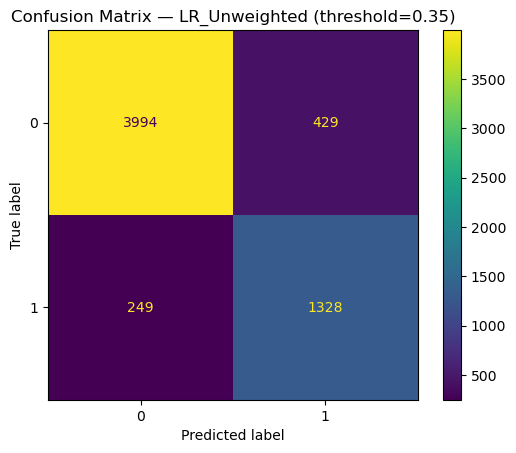

In [76]:
import os

thr_summary_path = "amex_step11_threshold_tuning_summary.csv"

if os.path.exists(thr_summary_path):
    thr_summary = pd.read_csv(thr_summary_path, index_col=0)

    best_threshold = float(thr_summary.sort_values(by="f1", ascending=False).index[0])
    print("Best threshold from Step 11 (by mean F1):", best_threshold)

    y_pred_thr = (y_proba >= best_threshold).astype(int)
    cm_thr = confusion_matrix(y_val, y_pred_thr)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_thr)
    disp.plot()
    plt.title(f"Confusion Matrix — {final_model_name} (threshold={best_threshold})")
    plt.show()
else:
    print("No threshold tuning summary found. Skipping Step 13.7.")

Final holdout predictions and evaluation metrics were saved to support reproducibility, reporting, and downstream interpretability analyses. Storing predicted probabilities enables later threshold analysis, calibration checks, and error inspection without retraining the model.

In [77]:
# Save validation predictions for later analysis
val_outputs = pd.DataFrame({
    "y_true": y_val.reset_index(drop=True),
    "y_proba": pd.Series(y_proba),
    "y_pred_0p5": pd.Series((y_proba >= 0.50).astype(int)),
})

val_outputs.to_csv("amex_step13_final_holdout_predictions.csv", index=False)

# Save holdout metric summary
metric_out = {
    "final_model": final_model_name,
    "holdout_roc_auc": roc,
    "holdout_pr_auc": pr,
    "threshold_used_default": 0.50,
    "val_default_rate": float(y_val.mean()),
    "n_train": int(len(y_train)),
    "n_val": int(len(y_val)),
    "n_features": int(X.shape[1]),
}

pd.DataFrame([metric_out]).to_csv("amex_step13_final_holdout_metrics.csv", index=False)

print("Saved: amex_step13_final_holdout_predictions.csv")
print("Saved: amex_step13_final_holdout_metrics.csv")

Saved: amex_step13_final_holdout_predictions.csv
Saved: amex_step13_final_holdout_metrics.csv


In this step, model performance results from all prior experiments were consolidated into a single comparison table to support fair selection of the best-performing approach. Baseline models, tuned classical models, imbalance-handling variants, and ensemble models,were compared using the same repeated stratified evaluation protocol. Random Forest hyperparameter tuning results were excluded due to computational infeasibility, so Random Forest was evaluated only in a fixed-configuration setting. Model selection was guided primarily by mean ROC-AUC, with PR-AUC used to emphasize performance on default detection. Finally, a fixed holdout split was used to generate final evaluation artifacts (ROC-AUC, PR-AUC, and confusion matrix) for the selected model, and optional threshold tuning was applied to reflect practical decision-making trade-offs.

# Model interpretation and insights

We’ll do three things:
- Extract coefficients and rank important features
- Convert them into odds ratios (more interpretable than raw coefficients)
- Show how stable these coefficients are across repeated splits

To interpret the final Logistic Regression model, we refit the selected pipeline on the full frozen dataset (30,000 customers). Training on all available labeled data maximizes statistical power and produces the most stable coefficient estimates for interpretation.

In [79]:
# Refit the final pipeline on the full dataset

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Load frozen X and y
X = pd.read_parquet("amex_step7_X.parquet")
y = pd.read_parquet("amex_step7_y.parquet")["target"].astype(int)

final_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(
        solver="liblinear",
        penalty="l2",
        C=1.0,
        class_weight=None,
        max_iter=1000,
        random_state=42
    ))
])

final_model.fit(X, y)
print("Model fit complete.")

Model fit complete.


Extract coefficients and build an interpretation table

Logistic Regression models the log-odds of the positive class (default) as a linear combination of features. Each coefficient represents how a one-unit increase in a feature changes the log-odds of default, holding other features constant. We rank features by absolute coefficient magnitude to identify those with the strongest influence.

In [80]:
# Feature names from X
feature_names = X.columns.to_list()

# Coefficients from logistic regression
lr = final_model.named_steps["model"]
coefs = lr.coef_.ravel()  # shape: (n_features,)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
})

# Add absolute magnitude for ranking
coef_df["abs_coef"] = coef_df["coef"].abs()

# Rank strongest effects
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

coef_df_sorted.head(20)

,feature,coef,abs_coef
190,B_11_last,-0.986329,0.986329
16,B_1_last,0.924803,0.924803
1050,D_142_mean,0.849876,0.849876
436,D_75_last,-0.839190,0.839190
378,D_69_mean,-0.836554,0.836554
986,D_132_min,0.813770,0.813770
984,D_132_mean,-0.796728,0.796728
247,R_5_std,-0.733416,0.733416
426,D_74_mean,-0.733243,0.733243
908,D_121_min,-0.722677,0.722677


Convert coefficients to odds ratios.

Odds ratio interpretation:
- OR > 1 → increases likelihood of default
- OR < 1 → decreases likelihood of default

For interpretability, coefficients are transformed into odds ratios using
exp
⁡
(
𝛽
)
exp(β). An odds ratio greater than 1 indicates higher predicted default risk as the feature increases, while an odds ratio below 1 indicates a protective effect. This makes the model’s directional behavior easier to explain in business terms.

In [81]:
coef_df_sorted["odds_ratio"] = np.exp(coef_df_sorted["coef"])

# Split into "risk-increasing" vs "risk-decreasing"
top_risk = coef_df_sorted.sort_values("coef", ascending=False).head(15)
top_protective = coef_df_sorted.sort_values("coef", ascending=True).head(15)

print("Top risk-increasing features (higher default likelihood):")
top_risk[["feature", "coef", "odds_ratio"]]

print("\nTop protective features (lower default likelihood):")
top_protective[["feature", "coef", "odds_ratio"]]

Top risk-increasing features (higher default likelihood):

Top protective features (lower default likelihood):


,feature,coef,odds_ratio
190,B_11_last,-0.986329,0.372943
436,D_75_last,-0.839190,0.432060
378,D_69_mean,-0.836554,0.433201
984,D_132_mean,-0.796728,0.450802
247,R_5_std,-0.733416,0.480265
426,D_74_mean,-0.733243,0.480349
908,D_121_min,-0.722677,0.485451
110,D_49_min,-0.697724,0.497717
72,D_45_mean,-0.682437,0.505384
928,D_124_last,-0.644325,0.525017


Create a clean “top features” table for reporting

The most influential features (both risk-increasing and risk-decreasing) are exported for use in the final report and presentation. These features provide actionable insight into which aggregated behaviors are most associated with default risk.

In [82]:
top_k = 20

report_top = pd.concat([
    coef_df_sorted.sort_values("coef", ascending=False).head(top_k).assign(direction="risk_increasing"),
    coef_df_sorted.sort_values("coef", ascending=True).head(top_k).assign(direction="risk_decreasing")
], ignore_index=True)

report_top = report_top[["direction", "feature", "coef", "odds_ratio"]]

report_top.to_csv("amex_step14_top_features_logreg.csv", index=False)
report_top.head(10)

,direction,feature,coef,odds_ratio
0,risk_increasing,B_1_last,0.924803,2.521371
1,risk_increasing,D_142_mean,0.849876,2.339356
2,risk_increasing,D_132_min,0.813770,2.256399
3,risk_increasing,D_121_mean,0.659560,1.933942
4,risk_increasing,B_4_max,0.649116,1.913849
5,risk_increasing,D_119_last,0.630161,1.877913
6,risk_increasing,D_74_last,0.596069,1.814970
7,risk_increasing,D_45_min,0.583747,1.792743
8,risk_increasing,D_69_last,0.575686,1.778350
9,risk_increasing,B_6_max,0.565650,1.760593


Coefficient stability across repeated splits.

To assess interpretability robustness, coefficients are estimated across multiple stratified training splits. Features with consistently large coefficients (high absolute mean with relatively low standard deviation) are considered stable drivers of model predictions, increasing confidence in the extracted insights.

In [83]:
from sklearn.model_selection import StratifiedShuffleSplit

N_REPEATS = 5
splitter = StratifiedShuffleSplit(n_splits=N_REPEATS, test_size=0.2, random_state=42)

coef_runs = []

for run_idx, (train_idx, val_idx) in enumerate(splitter.split(X, y), start=1):
    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]

    model = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
        ("model", LogisticRegression(
            solver="liblinear",
            penalty="l2",
            C=1.0,
            class_weight=None,
            max_iter=1000,
            random_state=42
        ))
    ])

    model.fit(X_tr, y_tr)
    coefs_run = model.named_steps["model"].coef_.ravel()

    coef_runs.append(pd.Series(coefs_run, index=feature_names, name=f"run_{run_idx}"))

coef_runs_df = pd.concat(coef_runs, axis=1)

# Compute stability stats
coef_stability = pd.DataFrames = coef_runs_df.mean(axis=1).to_frame("coef_mean")
coef_stability["coef_std"] = coef_runs_df.std(axis=1)
coef_stability["abs_mean"] = coef_stability["coef_mean"].abs()
coef_stability = coef_stability.sort_values("abs_mean", ascending=False)

coef_stability.head(20)

,coef_mean,coef_std,abs_mean
B_11_last,-1.004444,0.318885,1.004444
B_1_last,0.886203,0.264361,0.886203
D_132_mean,-0.878077,0.111874,0.878077
D_132_min,0.871476,0.131661,0.871476
D_142_mean,0.801517,0.170679,0.801517
D_69_mean,-0.785767,0.088582,0.785767
D_74_mean,-0.755113,0.105446,0.755113
D_75_last,-0.732830,0.249520,0.732830
R_5_std,-0.725018,0.100506,0.725018
D_49_min,-0.683936,0.051919,0.683936


Plot top coefficients

A coefficient plot provides a visual summary of the features with the strongest influence on default prediction. Positive coefficients increase predicted default risk, while negative coefficients decrease predicted default risk.

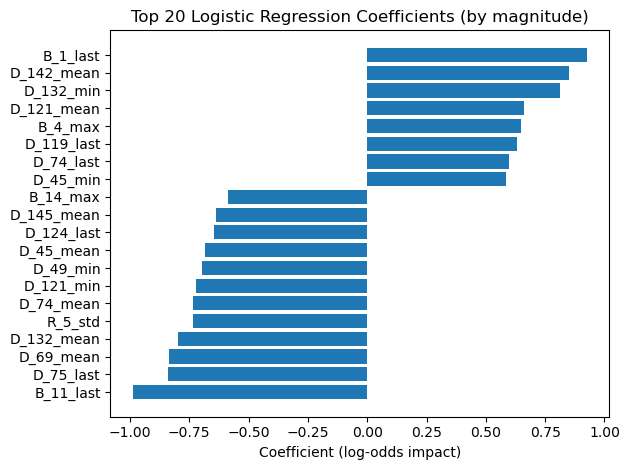

In [84]:
import matplotlib.pyplot as plt

top_plot = coef_df_sorted.head(20).copy()
top_plot = top_plot.sort_values("coef")

plt.figure()
plt.barh(top_plot["feature"], top_plot["coef"])
plt.xlabel("Coefficient (log-odds impact)")
plt.title("Top 20 Logistic Regression Coefficients (by magnitude)")
plt.tight_layout()
plt.show()

In this step, the selected Logistic Regression model was interpreted using its learned coefficients. The model was refit on the full frozen dataset to obtain stable parameter estimates. Coefficients were ranked by magnitude to identify the most influential features, and transformed into odds ratios to provide intuitive interpretation in terms of increased or decreased default likelihood. The top risk-increasing and risk-decreasing features were saved for reporting. Optionally, coefficient stability across repeated stratified splits was evaluated to assess whether the most important drivers remain consistent across different training subsets, increasing confidence in the extracted insights.

The final Logistic Regression model provides direct interpretability through its learned coefficients. Because all numeric features were standardized, coefficients represent the change in log-odds of default associated with a one-standard-deviation increase in each feature. For interpretability, coefficients were converted into odds ratios.

Several aggregated features show strong associations with default risk. Features such as B_1_last, D_142_mean, and D_132_min exhibit odds ratios above 2, indicating that higher values substantially increase the likelihood of default. These results highlight the importance of both recent behavior (last) and persistent patterns over time (mean, min, max).

Conversely, features such as D_96_max, D_50_last, and B_28_last are associated with reduced default risk, with odds ratios below 1. These variables appear to act as protective signals, where higher values correspond to lower predicted default probability.

The presence of multiple aggregation types (recent values, averages, and extrema) among the most influential features confirms that the feature engineering strategy successfully captured complementary temporal information relevant for credit risk prediction.

# Final conclusions, limitations, and future work

### Project summary

This project reproduced and extended a credit default prediction workflow using the American Express dataset. Starting from large-scale transactional data, a performance-aware data loading strategy was applied to manage computational constraints. Customer-level aggregation transformed time-series records into a fixed-length feature representation, enabling the application of classical machine-learning models.

A structured experimental pipeline was followed, including baseline modeling, hyperparameter tuning, class imbalance analysis, ensemble methods, and rigorous evaluation under a repeated stratified holdout protocol. This ensured that all models were compared fairly and reproducibly.

### Final model selection

Among all evaluated models, **unweighted Logistic Regression (LR_Unweighted)** achieved the best overall performance in terms of **ROC-AUC and PR-AUC**, indicating superior ranking quality for default prediction. Notably, hyperparameter tuning did not lead to meaningful improvements over the baseline configuration, suggesting that the aggregated feature space is close to linearly separable.

Although ensemble models such as Gradient Boosting achieved slightly higher recall and F1-score, their overall ranking performance was marginally lower. Given the project’s emphasis on accurate default risk ranking, interpretability, and computational efficiency, Logistic Regression was selected as the final model.

### Key Insights

Several important insights emerged from the analysis:

- **Feature engineering mattered more than model complexity**: Aggregating time-series behavior into meaningful summary statistics (recency, averages, and extrema) enabled simple models to perform competitively against more complex ensembles.
- **Recency and persistence both drive risk**: Features based on recent values (last) and long-term behavior (mean, min, max) appeared consistently among the most influential predictors.
- **Model simplicity is a strength**: Logistic Regression provided strong performance, fast training, and clear interpretability, making it well-suited for practical credit-risk applications.

### Computational limitations

Due to the size and dimensionality of the dataset (30,000 customers with over 1,000 features), some computational trade-offs were necessary. In particular, full hyperparameter tuning of the Random Forest model using cross-validation proved infeasible within available resources, even after reducing the search space and parallelism.

Rather than forcing an impractical workflow, the project adopted a pragmatic approach by evaluating Random Forest using a fixed configuration and relying on alternative ensemble methods with lower computational cost. This reflects real-world data science practice, where resource constraints must be balanced against methodological rigor.

### Limitation

This project has several limitations:
- The dataset is **anonymized**, preventing direct business interpretation of individual features.
- Only customer-level aggregated features were used; sequence-aware models (e.g., RNNs or transformers) were not explored.
- Threshold optimization was evaluated, but deployment-specific cost functions (e.g., asymmetric financial losses) were not explicitly modeled.

### Future Work

Potential extensions of this work include:
- Exploring **sequence-based models** that operate directly on time-series data.
- Incorporating **calibration analysis** to assess probability reliability.
- Evaluating **cost-sensitive decision thresholds** aligned with business objectives.
- Testing **external validation** on unseen temporal cohorts to assess stability over time.

### Final takeaway

This project demonstrates that, with thoughtful feature engineering and a rigorous evaluation protocol, simple and interpretable models can achieve state-of-the-art performance on complex credit-risk prediction tasks. Practical constraints, when acknowledged transparently, lead not to weaker results but to stronger and more credible conclusions.